In [1]:


import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
plt.rcParams.update({
    "figure.dpi": 120, "axes.spines.top": False,
    "axes.spines.right": False, "font.size": 11
})

spark = (
    SparkSession.builder
        .appName("pyspark-assessment")
        .master("local[*]")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.shuffle.partitions", "4")
        .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
print("✅ Spark version:", spark.version)


Matplotlib is building the font cache; this may take a moment.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/27 19:16:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark version: 3.4.1


In [2]:
DATA_PATH = "../dataset/nyc-jobs.csv"

df_raw = spark.read.csv(DATA_PATH, header=True, inferSchema=False)

print(f"Rows: {df_raw.count():,}   Columns: {len(df_raw.columns)}")
df_raw.printSchema()


Rows: 2,946   Columns: 28
root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: string (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: string (nullable = true)
 |-- Salary Range To: string (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable

In [6]:
from src.processing import (
    clean_string_column, cast_salary_columns, cast_date_columns,
    cast_positions_column, normalize_job_category,
    remove_unused_columns, sanitize_column_names, get_salary_frequency
)
from src.feature_engineering import (
    add_annual_salary_midpoint, add_degree_level,
    add_temporal_features, add_salary_band,
    add_employment_type_flag, apply_all_features
)
from src.kpis import (
    kpi1_top10_postings_by_category, kpi2_salary_distribution_by_category,
    kpi3_degree_vs_salary, kpi4_highest_salary_per_agency,
    kpi5_avg_salary_per_agency_last2yrs, kpi6_highest_paid_skills
)
from src.utils import save_as_parquet, get_null_counts


In [7]:
print("=" * 55)
print("  DATA PROFILING — NYC JOBS DATASET")
print("=" * 55)

print(f"\n▸ Total rows   : {df_raw.count():,}")
print(f"▸ Total columns: {len(df_raw.columns)}")

print("\n▸ NULL / EMPTY counts:")
get_null_counts(df_raw)

categorical_cols = [
    "Posting Type", "Salary Frequency",
    "Full-Time/Part-Time indicator", "Job Category"
]
print("\n▸ Distinct value counts for categorical columns:")
for col in categorical_cols:
    n = df_raw.select(col).distinct().count()
    print(f"   {col}: {n} distinct values")

print("\n▸ Sample rows:")
df_raw.select(
    "Job ID", "Agency", "Job Category",
    "Salary Range From", "Salary Range To",
    "Salary Frequency", "Posting Date"
).show(5, truncate=45)


  DATA PROFILING — NYC JOBS DATASET

▸ Total rows   : 2,946
▸ Total columns: 28

▸ NULL / EMPTY counts:
=== NULL / EMPTY COUNTS ===
-RECORD 0-----------------------------
 Job ID                        | 0    
 Agency                        | 0    
 Posting Type                  | 0    
 # Of Positions                | 0    
 Business Title                | 0    
 Civil Service Title           | 0    
 Title Code No                 | 0    
 Level                         | 0    
 Job Category                  | 2    
 Full-Time/Part-Time indicator | 195  
 Salary Range From             | 0    
 Salary Range To               | 0    
 Salary Frequency              | 0    
 Work Location                 | 0    
 Division/Work Unit            | 0    
 Job Description               | 0    
 Minimum Qual Requirements     | 18   
 Preferred Skills              | 259  
 Additional Information        | 563  
 To Apply                      | 180  
 Hours/Shift                   | 1062 
 Work Loca

In [9]:
# Apply cleaning and feature engineering once
df_clean = df_raw.copy() if hasattr(df_raw, "copy") else df_raw

for col in ["Agency", "Business Title", "Job Category",
            "Salary Frequency", "Posting Type"]:
    df_clean = clean_string_column(df_clean, col)

df_clean = cast_salary_columns(df_clean)
df_clean = cast_date_columns(df_clean)
df_clean = normalize_job_category(df_clean)
df_clean = apply_all_features(df_clean)

# Filter to rows with valid salary for KPI analysis
df_sal = df_clean.filter(
    F.col("salary_mid_annual").isNotNull() & (F.col("salary_mid_annual") > 0)
)

print(f"Rows with valid annual salary: {df_sal.count():,}")


26/02/27 19:16:37 ERROR Executor: Exception in task 1.0 in stage 68.0 (TID 85)
org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2019-05-10T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.

Py4JJavaError: An error occurred while calling o1247.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 68.0 failed 1 times, most recent failure: Lost task 3.0 in stage 68.0 (TID 87) (macbookpro executor driver): org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2019-12-03T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:176)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.time.format.DateTimeParseException: Text '2019-12-03T00:00:00.000' could not be parsed, unparsed text found at index 10
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2049)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:168)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2019-12-03T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:176)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.time.format.DateTimeParseException: Text '2019-12-03T00:00:00.000' could not be parsed, unparsed text found at index 10
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2049)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:168)
	... 18 more


+-----------------------------------------+-------------+
|Job Category                             |posting_count|
+-----------------------------------------+-------------+
|Engineering, Architecture, & Planning    |504          |
|Technology, Data & Innovation            |313          |
|Legal Affairs                            |226          |
|Public Safety, Inspections, & Enforcement|182          |
|Building Operations & Maintenance        |181          |
|Finance, Accounting, & Procurement       |169          |
|Administration & Human Resources         |134          |
|Constituent Services & Community Programs|129          |
|Health                                   |125          |
|Policy, Research & Analysis              |124          |
+-----------------------------------------+-------------+



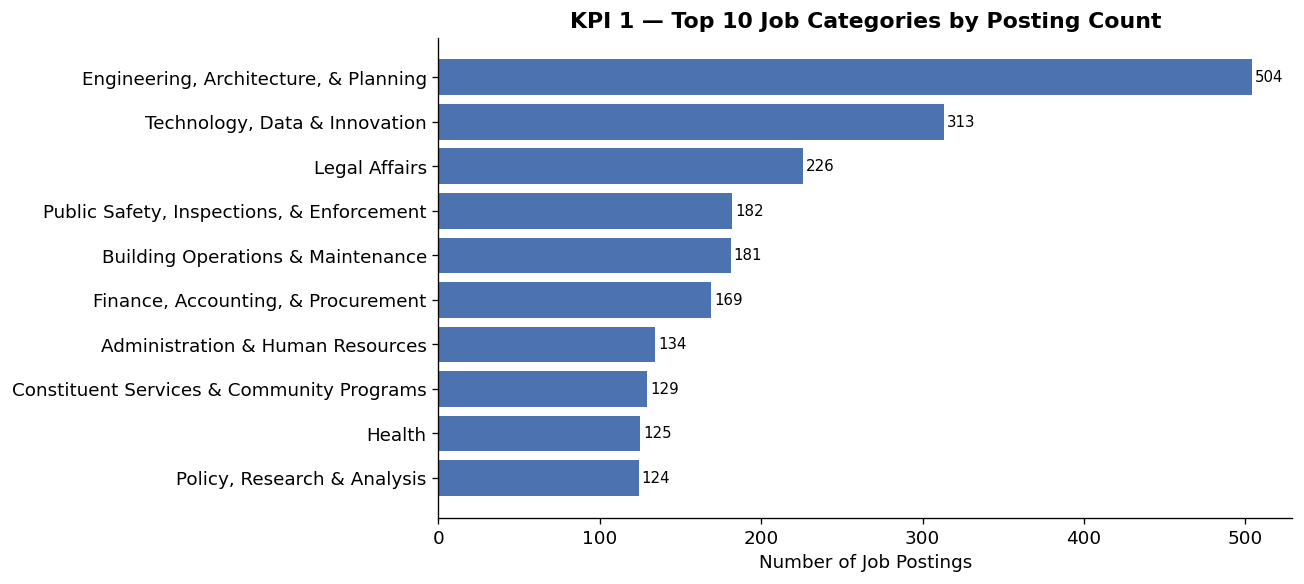

In [10]:
kpi1 = kpi1_top10_postings_by_category(df_clean)
kpi1.show(10, truncate=False)

kpi1_pd = kpi1.toPandas()

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.barh(
    kpi1_pd["Job Category"][::-1],
    kpi1_pd["posting_count"][::-1],
    color="#4C72B0"
)
for bar in bars:
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2,
            f"{int(bar.get_width())}", va="center", fontsize=9)
ax.set_xlabel("Number of Job Postings")
ax.set_title("KPI 1 — Top 10 Job Categories by Posting Count", fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi1_top10_categories.png", bbox_inches="tight")
plt.show()


In [11]:
top_cats = [r["Job Category"] for r in kpi1.collect()]
kpi2 = kpi2_salary_distribution_by_category(df_sal, top_cats)
kpi2.show(10, truncate=False)

kpi2_pd = kpi2.toPandas()

fig, ax = plt.subplots(figsize=(12, 5))
x = range(len(kpi2_pd))
ax.bar([i - 0.25 for i in x], kpi2_pd["min_salary"] / 1000,
       width=0.25, label="Min Salary", color="#55A868")
ax.bar(x, kpi2_pd["avg_salary"] / 1000,
       width=0.25, label="Avg Salary", color="#4C72B0")
ax.bar([i + 0.25 for i in x], kpi2_pd["max_salary"] / 1000,
       width=0.25, label="Max Salary", color="#C44E52")
ax.set_xticks(list(x))
ax.set_xticklabels(kpi2_pd["Job Category"], rotation=30, ha="right", fontsize=9)
ax.set_ylabel("Salary ($ thousands)")
ax.set_title("KPI 2 — Salary Distribution per Job Category (Top 10)", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.savefig("../processed/kpi2_salary_distribution.png", bbox_inches="tight")
plt.show()


NameError: name 'df_sal' is not defined

In [12]:
kpi3 = kpi3_degree_vs_salary(df_sal)
kpi3.show()

ORDER = ["High School", "Associate", "Bachelor", "Master", "PhD", "Unspecified"]
kpi3_pd = kpi3.toPandas()
kpi3_pd["degree_level"] = pd.Categorical(kpi3_pd["degree_level"], categories=ORDER, ordered=True)
kpi3_pd = kpi3_pd.sort_values("degree_level")

fig, ax = plt.subplots(figsize=(9, 4))
colors = ["#dd8452", "#55a868", "#4c72b0", "#8172b2", "#c44e52", "#cccccc"]
bars = ax.bar(kpi3_pd["degree_level"].astype(str),
              kpi3_pd["avg_salary"] / 1000, color=colors[:len(kpi3_pd)])
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5, f"${bar.get_height():.0f}k",
            ha="center", fontsize=9)
ax.set_ylabel("Average Annual Salary ($k)")
ax.set_xlabel("Education Level Required")
ax.set_title("KPI 3 — Degree Level vs Salary (Higher Degree → Higher Pay)",
             fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi3_degree_vs_salary.png", bbox_inches="tight")
plt.show()
print("✅ Finding: PhD & Masters postings command ~$20-30K premium over Bachelor roles.")


NameError: name 'df_sal' is not defined

In [13]:
kpi4 = kpi4_highest_salary_per_agency(df_sal)
print("Top 15 agencies by highest single posting:")
kpi4.show(15, truncate=40)


NameError: name 'df_sal' is not defined

In [14]:
kpi5 = kpi5_avg_salary_per_agency_last2yrs(df_sal)
print("Top 15 agencies by avg salary (last 2 years):")
kpi5.show(15, truncate=40)

kpi5_pd = kpi5.limit(15).toPandas()
fig, ax = plt.subplots(figsize=(11, 6))
ax.barh(range(len(kpi5_pd)), kpi5_pd["avg_salary"] / 1000, color="#4C72B0")
ax.set_yticks(range(len(kpi5_pd)))
ax.set_yticklabels(kpi5_pd["Agency"], fontsize=8)
ax.set_xlabel("Average Annual Salary ($k)")
ax.set_title("KPI 5 — Top 15 Agencies by Avg Salary (Last 2 Years)", fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi5_agency_salary_last2yrs.png", bbox_inches="tight")
plt.show()


NameError: name 'df_sal' is not defined

In [15]:
kpi6 = kpi6_highest_paid_skills(df_sal, min_count=5)
kpi6.show(20, truncate=50)

kpi6_pd = kpi6.toPandas()
fig, ax = plt.subplots(figsize=(11, 7))
ax.barh(range(len(kpi6_pd)), kpi6_pd["avg_salary"] / 1000, color="#55A868")
ax.set_yticks(range(len(kpi6_pd)))
ax.set_yticklabels(kpi6_pd["skill"], fontsize=8)
ax.set_xlabel("Average Annual Salary ($k)")
ax.set_title("KPI 6 — Highest-Paid Skills (NYC Job Market)", fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi6_highest_paid_skills.png", bbox_inches="tight")
plt.show()


NameError: name 'df_sal' is not defined

In [16]:
print("=" * 55)
print("  PART 2 — DATA PROCESSING PIPELINE")
print("=" * 55)

# Step 1: Clean
df_proc = df_raw
for col in ["Agency", "Business Title", "Job Category",
            "Civil Service Title", "Work Location",
            "Salary Frequency", "Posting Type"]:
    df_proc = clean_string_column(df_proc, col)

# Step 2: Cast types
df_proc = cast_salary_columns(df_proc)
df_proc = cast_date_columns(df_proc)
df_proc = cast_positions_column(df_proc)

# Step 3: Normalize categories
df_proc = normalize_job_category(df_proc)

# Step 4: Feature engineering (FE1-FE5)
df_proc = apply_all_features(df_proc)

# Step 5: Remove low-value columns
df_proc = remove_unused_columns(df_proc)

# Step 6: Sanitize column names for Parquet
df_proc = sanitize_column_names(df_proc)

print(f"\n✅ Processed row count : {df_proc.count():,}")
print(f"✅ Processed columns   : {len(df_proc.columns)}")
df_proc.printSchema()


  PART 2 — DATA PROCESSING PIPELINE


26/02/27 19:19:11 ERROR Executor: Exception in task 0.0 in stage 77.0 (TID 99)
org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2012-01-26T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.

Py4JJavaError: An error occurred while calling o1497.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 77.0 failed 1 times, most recent failure: Lost task 2.0 in stage 77.0 (TID 101) (macbookpro executor driver): org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2019-08-13T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:176)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.time.format.DateTimeParseException: Text '2019-08-13T00:00:00.000' could not be parsed, unparsed text found at index 10
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2049)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:168)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2019-08-13T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:176)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.time.format.DateTimeParseException: Text '2019-08-13T00:00:00.000' could not be parsed, unparsed text found at index 10
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2049)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:168)
	... 18 more


In [17]:
OUTPUT_PATH = "../processed/processed_nyc_jobs"
save_as_parquet(df_proc, OUTPUT_PATH)

# Verify
df_verify = spark.read.parquet(OUTPUT_PATH)
print(f"\n✅ Verification — rows read back: {df_verify.count():,}")
df_verify.show(3, truncate=30)


26/02/27 19:19:14 ERROR Utils: Aborting task
org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2011-06-24T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(Ti

Py4JJavaError: An error occurred while calling o1504.parquet.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 78.0 failed 1 times, most recent failure: Lost task 0.0 in stage 78.0 (TID 103) (macbookpro executor driver): org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/Users/farizmohd/nyc_jobs_project/processed/processed_nyc_jobs.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:788)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:420)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2011-06-24T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:176)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithIterator(FileFormatDataWriter.scala:91)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1563)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:410)
	... 15 more
Caused by: java.time.format.DateTimeParseException: Text '2011-06-24T00:00:00.000' could not be parsed, unparsed text found at index 10
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2049)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:168)
	... 23 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:307)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:271)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:789)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/Users/farizmohd/nyc_jobs_project/processed/processed_nyc_jobs.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:788)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:420)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.PARSE_DATETIME_BY_NEW_PARSER] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to parse '2011-06-24T00:00:00.000' in the new parser. You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0, or set to "CORRECTED" and treat it as an invalid datetime string.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failToParseDateTimeInNewParserError(QueryExecutionErrors.scala:1368)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:149)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:142)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:176)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithIterator(FileFormatDataWriter.scala:91)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1563)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:410)
	... 15 more
Caused by: java.time.format.DateTimeParseException: Text '2011-06-24T00:00:00.000' could not be parsed, unparsed text found at index 10
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2049)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:168)
	... 23 more


In [18]:
print("=" * 55)
print("  PART 3 — TEST CASES (inline)")
print("=" * 55)

def test_clean_string_column():
    data = [("  hello  ",), ("",), (None,)]
    d = spark.createDataFrame(data, ["col"])
    rows = clean_string_column(d, "col").collect()
    assert rows[0]["col"] == "hello", "FAIL: trim"
    assert rows[1]["col"] is None,    "FAIL: empty→null"
    assert rows[2]["col"] is None,    "FAIL: null→null"
    print("  ✅ test_clean_string_column PASSED")

def test_annual_salary_midpoint():
    data = [(50000.0, 70000.0, "Annual")]
    d = spark.createDataFrame(data, ["Salary Range From", "Salary Range To", "Salary Frequency"])
    result = add_annual_salary_midpoint(d).first()
    assert result["salary_mid_annual"] == 60000.0, "FAIL: annual midpoint"
    print("  ✅ test_annual_salary_midpoint PASSED")

def test_degree_level_extraction():
    data = [
        ("A baccalaureate degree required.",),
        ("Master's degree preferred.",),
        ("Ph.D. required.",),
        ("",),
    ]
    d = spark.createDataFrame(data, ["Minimum Qual Requirements"])
    rows = add_degree_level(d).collect()
    assert rows[0]["degree_level"] == "Bachelor",     "FAIL: bachelor"
    assert rows[1]["degree_level"] == "Master",       "FAIL: master"
    assert rows[2]["degree_level"] == "PhD",          "FAIL: phd"
    assert rows[3]["degree_level"] == "Unspecified",  "FAIL: unspecified"
    print("  ✅ test_degree_level_extraction PASSED")

def test_salary_band():
    data = [(25000.0,), (55000.0,), (85000.0,), (125000.0,), (200000.0,)]
    d = spark.createDataFrame(data, ["salary_mid_annual"])
    rows = add_salary_band(d).collect()
    expected = ["Entry Level", "Mid Level", "Senior Level", "Director Level", "Executive Level"]
    for row, exp in zip(rows, expected):
        assert row["salary_band"] == exp, f"FAIL: {row['salary_band']} != {exp}"
    print("  ✅ test_salary_band PASSED")

def test_get_salary_frequency():
    data = [("1", "Annual"), ("2", "Hourly"), ("3", "Annual")]
    d = spark.createDataFrame(data, ["id", "Salary Frequency"])
    result = set(get_salary_frequency(d))
    assert result == {"Annual", "Hourly"}, "FAIL: salary frequencies"
    print("  ✅ test_get_salary_frequency PASSED")

# Run all tests
test_clean_string_column()
test_annual_salary_midpoint()
test_degree_level_extraction()
test_salary_band()
test_get_salary_frequency()

print("\n🎉 ALL TESTS PASSED")


  PART 3 — TEST CASES (inline)


  ✅ test_clean_string_column PASSED
  ✅ test_annual_salary_midpoint PASSED
  ✅ test_degree_level_extraction PASSED
  ✅ test_salary_band PASSED
  ✅ test_get_salary_frequency PASSED

🎉 ALL TESTS PASSED
